In [1]:
# Import own modules
# SelfSupervised
import modules.selfsupervised.simclr_model as sm 
import modules.selfsupervised.simclr_train as smtr
# Evaluation
import modules.evaluation.lin_eval_testmoduls as let
# Utils
import modules.utils.transformations as t 
import modules.utils.loss_functions as lf
import modules.utils.lars as lars
# Settings
import modules.utils.get_data as get 
# Reporting 
import modules.utils.reporting as report 
# Saving Model
import modules.utils.save_model as savem
# Get Model
import modules.utils.get_model as gm 
# Import extern modules
import argparse
import torchvision
import torch 
import torch.nn as nn
from torch.nn.parallel import DataParallel
import math 
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Create an Argparser
parser = argparse.ArgumentParser(description='Train simCLRv1 on CIFAR-10')
# Model-Architecture
parser.add_argument('-a', '--arch', default='resnet18')
# lr: 0.06 for batch 512 (or 0.03 for batch 256) 0.12 for 1024?
parser.add_argument('--lr', '--learning-rate', default=1e-3, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=20, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--schedule', default=[1020, 1060], nargs='*', type=int, help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', default="False", type=str, help='use cosine lr schedule')
parser.add_argument('--squared', default="False", type=str, help='use square lr schedule')
parser.add_argument('--batch-size', default=768, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=1e-6, type=float, metavar='W', help='weight decay')
parser.add_argument('--dataset', default="IMAGENET", type=str, metavar='W', help='dataset')
parser.add_argument('--dataset-dir', default="data/imagenet128", type=str, metavar='W', help='dataset directory')
parser.add_argument('--optimizer', default="adam", type=str, metavar='W', help='Adam, SGD, Lars')
# SIMCLR specific configs:
parser.add_argument('--dim', default=128, type=int, help='feature dimension')
parser.add_argument('--t', default=0.1, type=float, help='softmax temperature')
parser.add_argument('--numberviews', default=2, type=int, help='Number of Views created for Avg.Loss')
# Training/Test Settings
parser.add_argument('--model-dir', default="", type=str, metavar='W', help='if test true give model dir!')
parser.add_argument('--model-name', default="", type=str, metavar='W', help='if test true give model dir!')
# Linear Evaluation
parser.add_argument('--epochs-lineval', default=100, type=int, metavar='N', help='number of total epochs to run in linEval')
# Labels
parser.add_argument('--labels', default="full", type=str, metavar='N', help='1%, 10% or full labelled data sets are supported')
# Multiple GPUs
parser.add_argument('--dataparallel', default="True", type=str, metavar='W', help='multiple gpus true or false')
# Reload
parser.add_argument('--reload', default="False", type=str, metavar='W', help='reload true or false')
# Verbose
parser.add_argument('--verbose', default="True", type=str, help='True if you want to evaluate your representations after each epoch (obviously SLOWER!)')

# Set up args
args = parser.parse_args("")

In [3]:
# Convert 
args.dataparallel = True if str.lower(args.dataparallel) == "true" else False
args.reload = True if str.lower(args.reload) == 'true' else False
args.verbose = True if str.lower(args.verbose) == 'true' else False
args.cos = True if str.lower(args.cos) == 'true' else False
args.squared = True if str.lower(args.squared) == 'true' else False
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.num_gpus = torch.cuda.device_count()

In [4]:
args.dataset = "CIFAR10"
#args.labels = "10%"

In [5]:
def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        extra_point=plt.plot(extra_pt[0],extra_pt[1],'k.',label=extra_pt_label, markersize=16)
        if extra_pt_label:
            legend.append(extra_pt_label)

        # END OF YOUR CODE #
        
    plt.vlines(20, 0, 1)
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

In [6]:
class modelSIMCLR(nn.Module):
    """ SIMCLR MODEL"""

    def __init__(self, encoder, n_features, loss_func, dim=128, T=0.1):
        """ 
        Input:
            encoder: Encoder you want to use to get feature representations (eg. resnet18)
            n_features: Type int - The dimension of the encoder output, your feature dimension
            loss_func: The loss function you want to use (from loss_functions.py)
            eval_model: If you have labels, the model you want to evaluate your feature representations on
            eval_optimizer: The optimizer for your eval_model
            dim: Type int - The dimension the projection head outputs
            T: Type int - The temperature parameter in the contrastive loss function

            Creates a SIMCLR model
        """
        # Inherit from nn module (standard)
        super(modelSIMCLR, self).__init__()
        self.T = T
        self.n_features = n_features
        self.loss_func = loss_func
        # create the encoder
        self.encoder_f = encoder
        self.encoder_f.fc = torch.nn.Identity()
        #self.encoder_f.fc = torch.nn.Linear(512, 512)
        # Create Projection Head
        self.mlp = nn.Sequential (
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(num_features=self.n_features),
            nn.ReLU(),
            nn.Linear(self.n_features, dim, bias=False),
            nn.BatchNorm1d(num_features=dim)
        )
        
        self.switch = False
        self.classifier = torch.nn.Linear(512,10)

    def forward(self, im1, im2=None, args=None):
        """
        Input:
            im1: a batch of query images
            im2: differently augmented query images

            Runs the encoder, runs the projection head, normalizes the output of the projection head 
            and returns the contrastive loss given the loss_func from loss_functions.py 
        """
       
        if self.switch:
            h_i = self.encoder_f(im1)
            return self.classifier(h_i)
        else: 
             # Get Representations
            h_i = self.encoder_f(im1)
            h_j = self.encoder_f(im2)
            z_i = self.mlp(h_i)
            z_j = self.mlp(h_j)
            # Normalize Feature Embeddings
            z_i = nn.functional.normalize(z_i, p=2, dim=1)
            z_j = nn.functional.normalize(z_j, p=2, dim=1) 

            return self.loss_func(z_i, z_j, self.T)


In [7]:
# Set Reporting up
#writer_train, writer_val, mkdirpath = report.setReportingUp_trainingSimclr(args)
# Get Data
train_loader, train_loader_nonaug, val_loader = get.data_trainingSimclr(args)
# Get encoder
encoder = get.encoder(args)
args.featureDim, args.numberClasses, epoch_start = encoder.fc.in_features, get.numberClasses(args), 1
# Choose Model
model = modelSIMCLR(encoder, args.featureDim, lf.contrastive_loss_cosine_extra, dim=args.dim, T=args.t)
# To device
model = model.to(args.device)
# Get Optimizer
optimizer = get.optimizer_training(model, args)
# Check Dataparallel
if args.dataparallel: model = DataParallel(model)
    
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [25]:
args.epochs = 20

In [26]:
# Start training
train_losses =[]
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epoch_start, args.epochs + 1):
    train_loss, neg_sim, pos_sim, lr = smtr.train(model, train_loader, optimizer, epoch, args)
    """
    if (epoch % 1) == 0:
        model.module.switch = True
        for _ in range(1):
            train_loss, train_acc = let.train_lr(train_loader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
            val_loss, val_acc = let.test_lr(val_loader, model, criterion, epoch, args.epochs, args)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
        model.module.switch = False
       """
       
model.module.switch = True
for _ in range(20):
    train_loss, train_acc = let.train_lr(train_loader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
    val_loss, val_acc = let.test_lr(val_loader, model, criterion, epoch, args.epochs, args)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

  0%|          | 0/66 [00:00<?, ?it/s]/home/dustin/.conda/envs/usl/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Train Epoch: [1/20], lr: 0.001000, Loss_Contrast: 5.2694, Nsim: 0.0299, Psim: 0.4709: 100%|██████████| 66/66 [00:38<00:00,  1.73it/s]
Train Epoch: [2/20], lr: 0.001000, Loss_Contrast: 3.9092, Nsim: 0.0037, Psim: 0.5254: 100%|██████████| 66/66 [00:38<00:00,  1.71it/s]
Train Epoch: [3/20], lr: 0.001000, Loss_Contrast: 3.3445, Nsim: 0.0039, Psim: 0.5593: 100%|██████████| 66/66 [00:39<00:00,  1.67it/s]
Train Epoch: [4/20], lr: 0.001000, Loss_Contrast: 3.0185, Nsim: 0.0035, Psim: 0.5831: 100%|██████████| 66/66 [00:39<00:00,  1.68it/s]
Train Epoch: [5/20], lr: 0.001000, Loss_Contrast: 2.7791, Nsim: 0.0027, Psim: 0.5992: 100%|██████████| 66/66 [00:39<00:00,  1.68it/s]
T

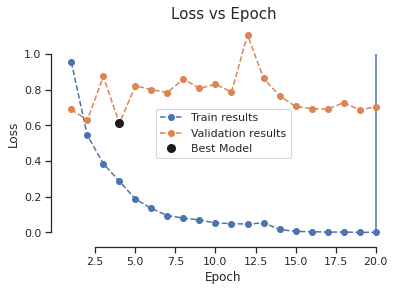

Best Loss-Value for Validation: 0.6105807253292629 at Epoch 4


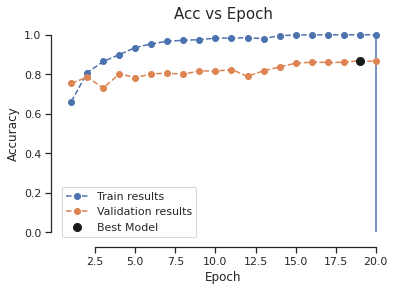

Best Accuracy for Validation: 0.8688 at Epoch 19


In [27]:
min_value = min(val_losses)
min_index = val_losses.index(min_value)+1

plot("Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=(min_index, min_value), extra_pt_label="Best Model")
print(f"Best Loss-Value for Validation: {min_value} at Epoch {min_index}")

max_value = max(val_accs)
max_index = val_accs.index(max_value)+1
plot("Acc vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=(max_index, max_value), extra_pt_label="Best Model")
print(f"Best Accuracy for Validation: {max_value} at Epoch {max_index}")

In [9]:
# Set Reporting up
#writer_train, writer_val, mkdirpath = report.setReportingUp_trainingSimclr(args)
# Get Data
train_loader, train_loader_nonaug, val_loader = get.data_trainingSimclr(args)
# Get encoder
encoder = get.encoder(args)
args.featureDim, args.numberClasses, epoch_start = encoder.fc.in_features, get.numberClasses(args), 1
# Choose Model
model = modelSIMCLR(encoder, args.featureDim, lf.contrastive_loss_cosine_extra, dim=args.dim, T=args.t)
# To device
model = model.to(args.device)
# Get Optimizer
optimizer = get.optimizer_training(model, args)
# Check Dataparallel
if args.dataparallel: model = DataParallel(model)
    
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
args.epochs = 100

In [11]:
# Start training
train_losses =[]
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epoch_start, args.epochs + 1):
    train_loss, neg_sim, pos_sim, lr = smtr.train(model, train_loader, optimizer, epoch, args)
    """
    if (epoch % 1) == 0:
        model.module.switch = True
        for _ in range(1):
            train_loss, train_acc = let.train_lr(train_loader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
            val_loss, val_acc = let.test_lr(val_loader, model, criterion, epoch, args.epochs, args)
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
        model.module.switch = False
       """
       
model.module.switch = True
for _ in range(100):
    train_loss, train_acc = let.train_lr(train_loader_nonaug, model, criterion, optimizer, epoch, args.epochs, args)
    val_loss, val_acc = let.test_lr(val_loader, model, criterion, epoch, args.epochs, args)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

  0%|          | 0/66 [00:00<?, ?it/s]/home/dustin/.conda/envs/usl/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Train Epoch: [1/100], lr: 0.001000, Loss_Contrast: 5.0318, Nsim: 0.0040, Psim: 0.4425: 100%|██████████| 66/66 [00:40<00:00,  1.65it/s]
Train Epoch: [2/100], lr: 0.001000, Loss_Contrast: 3.7767, Nsim: 0.0038, Psim: 0.5325: 100%|██████████| 66/66 [00:38<00:00,  1.70it/s]
Train Epoch: [3/100], lr: 0.001000, Loss_Contrast: 3.2521, Nsim: 0.0043, Psim: 0.5690: 100%|██████████| 66/66 [00:39<00:00,  1.68it/s]
Train Epoch: [4/100], lr: 0.001000, Loss_Contrast: 2.9386, Nsim: 0.0036, Psim: 0.5888: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]
Train Epoch: [5/100], lr: 0.001000, Loss_Contrast: 2.7191, Nsim: 0.0025, Psim: 0.6044: 100%|██████████| 66/66 [00:39<00:00,  1.66it

Train Epoch: [58/100], lr: 0.001000, Loss_Contrast: 1.4388, Nsim: 0.0001, Psim: 0.7095: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]
Train Epoch: [59/100], lr: 0.001000, Loss_Contrast: 1.4509, Nsim: 0.0001, Psim: 0.7077: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]
Train Epoch: [60/100], lr: 0.001000, Loss_Contrast: 1.4417, Nsim: 0.0001, Psim: 0.7091: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]
Train Epoch: [61/100], lr: 0.001000, Loss_Contrast: 1.4315, Nsim: 0.0001, Psim: 0.7097: 100%|██████████| 66/66 [00:39<00:00,  1.66it/s]
Train Epoch: [62/100], lr: 0.001000, Loss_Contrast: 1.4193, Nsim: 0.0001, Psim: 0.7121: 100%|██████████| 66/66 [00:39<00:00,  1.67it/s]
Train Epoch: [63/100], lr: 0.001000, Loss_Contrast: 1.4091, Nsim: 0.0001, Psim: 0.7124: 100%|██████████| 66/66 [00:39<00:00,  1.67it/s]
Train Epoch: [64/100], lr: 0.001000, Loss_Contrast: 1.4131, Nsim: 0.0001, Psim: 0.7125: 100%|██████████| 66/66 [00:39<00:00,  1.67it/s]
Train Epoch: [65/100], lr: 0.001000, Loss_Contra

Val Epoch: [100/100], Loss: 0.4712, Acc_Val: 0.8956: 100%|██████████| 7/7 [00:00<00:00, 10.01it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0010, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.12it/s]
Val Epoch: [100/100], Loss: 0.4600, Acc_Val: 0.9026: 100%|██████████| 7/7 [00:00<00:00,  9.40it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0005, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.12it/s]
Val Epoch: [100/100], Loss: 0.4513, Acc_Val: 0.9034: 100%|██████████| 7/7 [00:00<00:00,  9.48it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0003, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.13it/s]
Val Epoch: [100/100], Loss: 0.4533, Acc_Val: 0.9016: 100%|██████████| 7/7 [00:00<00:00,  9.66it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0004, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.12it/s]
Val Epoch: [100/100], Loss: 0.4769, Acc_Val: 0.9042: 100%|██████████| 7/7 [00:00<00:00,  9.59it/s]
Train Epoch: [100/100], lr: 0

Train Epoch: [100/100], lr: 0.001000, Loss: 0.0005, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.13it/s]
Val Epoch: [100/100], Loss: 0.4896, Acc_Val: 0.9012: 100%|██████████| 7/7 [00:00<00:00,  9.30it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0004, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.13it/s]
Val Epoch: [100/100], Loss: 0.5336, Acc_Val: 0.8994: 100%|██████████| 7/7 [00:00<00:00,  9.72it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0002, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.12it/s]
Val Epoch: [100/100], Loss: 0.5126, Acc_Val: 0.9030: 100%|██████████| 7/7 [00:00<00:00,  9.12it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0001, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.13it/s]
Val Epoch: [100/100], Loss: 0.5133, Acc_Val: 0.9046: 100%|██████████| 7/7 [00:00<00:00,  9.68it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0004, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.13it/s]
Val Epoch

Val Epoch: [100/100], Loss: 0.5561, Acc_Val: 0.8914: 100%|██████████| 7/7 [00:00<00:00,  9.76it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0017, Acc_Train: 0.9995: 100%|██████████| 66/66 [00:21<00:00,  3.13it/s]
Val Epoch: [100/100], Loss: 0.5622, Acc_Val: 0.8928: 100%|██████████| 7/7 [00:00<00:00,  9.50it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0008, Acc_Train: 0.9999: 100%|██████████| 66/66 [00:21<00:00,  3.13it/s]
Val Epoch: [100/100], Loss: 0.5305, Acc_Val: 0.9008: 100%|██████████| 7/7 [00:00<00:00,  9.57it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0003, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.13it/s]
Val Epoch: [100/100], Loss: 0.5414, Acc_Val: 0.9008: 100%|██████████| 7/7 [00:00<00:00,  9.58it/s]
Train Epoch: [100/100], lr: 0.001000, Loss: 0.0001, Acc_Train: 1.0000: 100%|██████████| 66/66 [00:21<00:00,  3.14it/s]
Val Epoch: [100/100], Loss: 0.5402, Acc_Val: 0.9004: 100%|██████████| 7/7 [00:00<00:00,  9.86it/s]
Train Epoch: [100/100], lr: 0

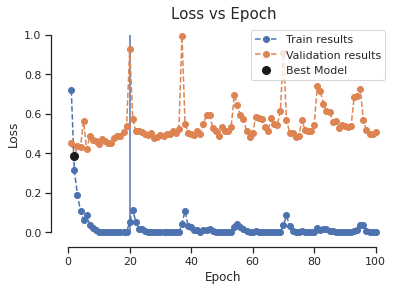

Best Loss-Value for Validation: 0.38616371154785156 at Epoch 2


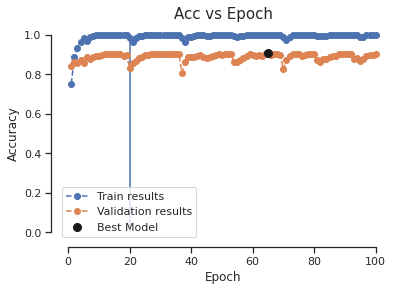

Best Accuracy for Validation: 0.9058 at Epoch 65


In [12]:
min_value = min(val_losses)
min_index = val_losses.index(min_value)+1

plot("Loss vs Epoch", "Loss", train_losses, val_losses, yscale='linear', save_path=None, 
         extra_pt=(min_index, min_value), extra_pt_label="Best Model")
print(f"Best Loss-Value for Validation: {min_value} at Epoch {min_index}")

max_value = max(val_accs)
max_index = val_accs.index(max_value)+1
plot("Acc vs Epoch", "Accuracy", train_accs, val_accs, yscale='linear', save_path=None, 
         extra_pt=(max_index, max_value), extra_pt_label="Best Model")
print(f"Best Accuracy for Validation: {max_value} at Epoch {max_index}")